<a href="https://colab.research.google.com/github/dardeshna/frc-stuffs/blob/master/notebooks/arm_design/double_jointed_arm_design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Double-Jointed Arm Design

In [ ]:
# setup
from math import sin, cos, pi

import numpy as np
import scipy.optimize
import scipy.interpolate

from matplotlib import pyplot as plt
%config InlineBackend.figure_formats = ['svg']
plt.style.use('default')

## Design parameters

In [ ]:
# target manipulator positions
intake = (-4, 0)
mid = (22.75, 34)
high = (39.75, 46)

# wrist geometry
wrist_to_cone_center = 8
cone_center_to_bottom = 9

# starting config
starting_config_front = -3
starting_config_back = -27
starting_config_height = 54

# cone tilt
cone_tilt_min = 20
cone_tilt_max = 40

# pivot bounds
x0_min = -25
x0_max = -20
y0_min = 3
y0_max = 6

# arm length bounds
l1_min = 10
l1_max = 70
l2_min = 10
l2_max = 70

# weighting
w_start_height = 2 # [0, +inf)
w_actuation_angle = 1 # [0, +inf)

## Plotting utils

In [ ]:
def plot_env():

    plt.gca().axis('equal')

    plt.plot(*mid, 'ko')
    plt.plot(*high, 'ko')
    plt.plot(*intake, 'ko')

    plt.plot(
        [starting_config_front, starting_config_front, starting_config_back, starting_config_back],
        [0, starting_config_height, starting_config_height, 0],
        '--',
        color='lightgrey'
    )

    plt.plot(
        [x0_min, x0_min, x0_max, x0_max, x0_min],
        [y0_min, y0_max, y0_max, y0_min, y0_min],
        '--',
        color='lightgrey'
    )


def plot_config(x0, y0, l1, l2, theta1, theta2, theta3, armspec='b-', jointspec='ro'):

    x = np.array([
        x0,
        x1 := x0 + l1 * cos(theta1),
        x2 := x1 + l2 * cos(theta1 + theta2),
        x3 := x2 + wrist_to_cone_center * cos(theta1 + theta2 + theta3),
        x4 := x3 + cone_center_to_bottom * cos(theta1 + theta2 + theta3 - pi/2),
    ])

    y = np.array([
        y0,
        y1 := y0 + l1 * sin(theta1),
        y2 := y1 + l2 * sin(theta1 + theta2),
        y3 := y2 + wrist_to_cone_center * sin(theta1 + theta2 + theta3),
        y4 := y3 + cone_center_to_bottom * sin(theta1 + theta2 + theta3 - pi/2),
    ])
    
    plt.plot(x, y, armspec)
    plt.plot(x[[0,1,2,4]], y[[0,1,2,4]], jointspec)

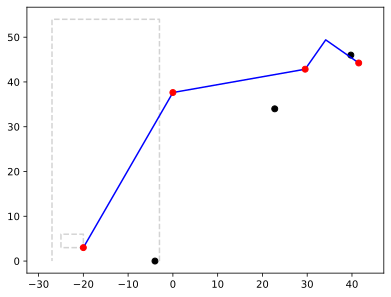

In [ ]:
# example configuration

plt.figure()

plot_env()
plot_config(-20, 3, 40, 30, np.radians(60), np.radians(-50), np.radians(45), 'b-', 'ro')

plt.show()

## Optimization problem

Forward kinematics:

\begin{equation*}
\begin{bmatrix}
x_f \\ y_f
\end{bmatrix} = \begin{bmatrix}
x_0 + l_1 \cos(\theta_1) + l_2 \cos(\theta_1 + \theta_2) + c \cos(\theta_1 + \theta_2 + \theta_3) + d \cos (\theta_1 + \theta_2 + \theta_3 - \frac{\pi}{2}) \\
y_0 + l_1 \sin(\theta_1) + l_2 \sin(\theta_1 + \theta_2) + c \sin(\theta_1 + \theta_2 + \theta_3) + d \sin (\theta_1 + \theta_2 + \theta_3 - \frac{\pi}{2})
\end{bmatrix}
\end{equation*}

* $x_0, y_0$: base pivot location
* $\theta_1, \theta_2, \theta_3$: joint angles
* $l_1, l_2$: arm lengths
* $c$: distance from wrist pivot to cone centerline
* $d$: distance from wrist centerline to cone bottom

In [ ]:
def unpack(x):

    x0, y0 = x[0], x[1]
    l1, l2 = x[2], x[3]

    theta1 = x[4:6]
    theta2 = x[6:9]
    theta3 = x[9:]

    return x0, y0, l1, l2, theta1, theta2, theta3

def pack(x0, y0, l1, l2, theta1, theta2, theta3):
    
    return np.r_[x0, y0, l1, l2, theta1, theta2, theta3]

def forward_kinematics(x0, y0, l1, l2, theta1, theta2, theta3):

    xf = x0 + l1 * cos(theta1) + l2 * cos(theta1 + theta2) + wrist_to_cone_center * cos(theta1 + theta2 + theta3) + cone_center_to_bottom * cos(theta1 + theta2 + theta3 - pi/2)
    yf = y0 + l1 * sin(theta1) + l2 * sin(theta1 + theta2) + wrist_to_cone_center * sin(theta1 + theta2 + theta3) + cone_center_to_bottom * sin(theta1 + theta2 + theta3 - pi/2)

    return xf, yf

def f(x):

    x0, y0, l1, l2, theta1, theta2, theta3 = unpack(x)

    start_height = y0 + l1 * sin(theta1[0])
    actuation_angle = np.degrees(theta1[0]-theta1[1])

    return w_start_height * start_height + w_actuation_angle * actuation_angle 

def c_eq(x):

    x0, y0, l1, l2, theta1, theta2, theta3 = unpack(x)

    x_intake, y_intake = forward_kinematics(x0, y0, l1, l2, theta1[0], theta2[0], theta3[0])
    x_mid, y_mid = forward_kinematics(x0, y0, l1, l2, theta1[0], theta2[1], theta3[1])
    x_high, y_high = forward_kinematics(x0, y0, l1, l2, theta1[1], theta2[2], theta3[2])

    return np.r_[
        x_intake - intake[0], # intake x
        y_intake - intake[1], # intake y
        theta1[0] + theta2[0] + theta3[0], # wrist is horizontal when intaking

        x_mid - mid[0], # mid x
        y_mid - mid[1], # mid y

        x_high - high[0], # high x
        y_high - high[1], # high y
    ]

def c_ineq(x):

    x0, y0, l1, l2, theta1, theta2, theta3 = unpack(x)

    return np.r_[
        theta1[0] + theta2[1] + theta3[1] - np.radians(cone_tilt_min), # mid min cone tilt
        np.radians(cone_tilt_max) - (theta1[0] + theta2[1] + theta3[1]), # mid max cone tilt

        theta1[1] + theta2[2] + theta3[2] - np.radians(cone_tilt_min), # high min cone tilt
        np.radians(cone_tilt_max) - (theta1[1] + theta2[2] + theta3[2]), # high max cone tilt

        starting_config_height - (y0 + l1 * sin(theta1[0])), # starting config height limit
        starting_config_front - (x0 + l1 * cos(theta1[0])),  # starting config front frame perimeter
        x0 + l1 * cos(theta1[0]) - starting_config_back # starting config rear frame perimeter
    ]


bounds = [
    (x0_min, x0_max),
    (y0_min, y0_max),
    (l1_min, l1_max),
    (l2_min, l2_max),
    (0, pi),
    (0, pi),
    (-pi, pi/2),
    (-pi, pi/2),
    (-pi, pi/2),
    (-3*pi/4, 3*pi/4),
    (-3*pi/4, 3*pi/4),
    (-3*pi/4, 3*pi/4),
]

Initial guess:

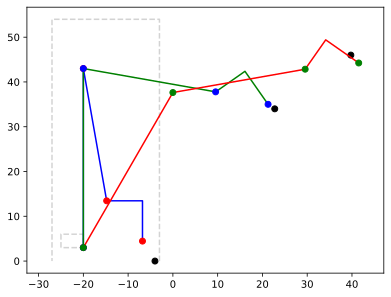

In [ ]:
x0_init = -20
y0_init = 3
l1_init = 40
l2_init = 30
theta1_init = [np.radians(90), np.radians(60)]
theta2_init = [np.radians(-170), np.radians(-100), np.radians(-50)]
theta3_init = [np.radians(80), np.radians(45), np.radians(45)]

x_init = pack(x0_init, y0_init, l1_init, l2_init, theta1_init, theta2_init, theta3_init)

plt.figure()

plot_env()

plot_config(x0_init, y0_init, l1_init, l2_init, theta1_init[0], theta2_init[0], theta3_init[0], 'b-', 'ro')
plot_config(x0_init, y0_init, l1_init, l2_init, theta1_init[0], theta2_init[1], theta3_init[1], 'g-', 'bo')
plot_config(x0_init, y0_init, l1_init, l2_init, theta1_init[1], theta2_init[2], theta3_init[2], 'r-', 'go')

plt.show()

Call `scipy.optimize.minimize()`:

In [ ]:
res = scipy.optimize.minimize(
    fun = f,
    x0 = x_init,
    bounds = bounds,
    constraints = [
        {
            'type': 'eq',
            'fun': c_eq,
        },
        {
            'type': 'ineq',
            'fun': c_ineq,
        }
    ]
)

## Plot results

starting config height:  41.50162261075432
angle of actuation:  25.831415425653194


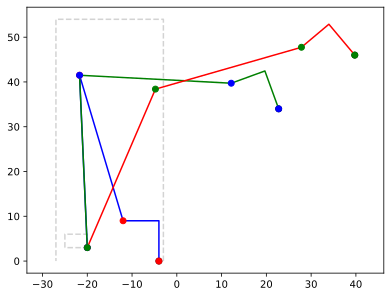

In [ ]:
x0, y0, l1, l2, theta1, theta2, theta3 = unpack(res['x'])

start_height = y0 + l1 * sin(theta1[0])
actuation_angle = np.degrees(theta1[0]-theta1[1])

print("starting config height: ", start_height)
print("angle of actuation: ", actuation_angle)

plt.figure()

plot_env()

plot_config(x0, y0, l1, l2, theta1[0], theta2[0], theta3[0], 'b-', 'ro')
plot_config(x0, y0, l1, l2, theta1[0], theta2[1], theta3[1], 'g-', 'bo')
plot_config(x0, y0, l1, l2, theta1[1], theta2[2], theta3[2], 'r-', 'go')

plt.show()